# Gabor Orientation Tuning with DJ StimuliSets

In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import numpy as np

import nnvision
from nnvision.tables.main import Recording
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

from insilico_stimuli.tables.main import InsilicoStimuliSet, StimuliOptimizeMethod, OptimisedStimuliTemplate
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

Connecting pawelp@134.2.168.16:3306


## StimuliSets table
The StimuliSets table contains the information necessary to construct the stimuli sets necessary for the experiments, in this case it will be orientation tuning.

In [2]:
InsilicoStimuliSet()

set_fn name of the set function,set_hash hash of the set config,set_config set configuration object,set_ts UTZ timestamp at time of insertion,set_comment a short comment describing the set


Using the insilico_stimuli framework you would define the stimulus set as follows

In [3]:
canvas_size         = [41, 41]
sizes               = FiniteParameter([20])
spatial_frequencies = FiniteParameter([1/5])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 25)])
phases              = FiniteParameter([np.pi]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([0.5])
locations           = FiniteParameter([[20, 20]])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

However, this is indepenedent of DataJoint, so we will need to define this set in the StimuliSets table.

## Set function
You need to provide the function which constructs the stimuli. In this case it is the Gabor set from the insilico_stimuli framework.

In [4]:
set_fn = 'insilico_stimuli.stimuli.GaborSet'

## Set Configuration
Having defined the stimulus set function, you can now proceed to define the set_config. It contains all the parameters necessary for the class constructor to build the stimuli. The format is defined as: the top most keys are the keys for the arguments (e.g. sizes), they contain *path* and *args* keys, which point to the type constructor (e.g. Finite Parameter) and the arguments which are passed to the type constructor. In the case when you don't need a custom type, you can just have the *args* key which points directly to the parameters of the keyword argument (e.g. canvas_size=[41, 41] is given as {"canvas_size": [41, 41]})

In [5]:
set_config = {
    "sizes": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[20]]
    },
    "spatial_frequencies": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[1/5]]
    },
    "contrasts": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[.5]]
    },
    "orientations": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[float(val) for val in np.linspace(0.0, np.pi, 25)]]
    },
    "phases": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[np.pi]]
    },
    "grey_levels": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[0.0]]
    },
    "eccentricities": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[0.5]]
    },
    "locations": {
        "path": 'insilico_stimuli.parameters.FiniteParameter',
        "args": [[[20.0, 20.0]]]
    }
}

## Adding the Set to the table
You can now add the set to the StimuliSets table with a meaningful comment.

In [6]:
InsilicoStimuliSet().add_set(set_fn, set_config, 'GaborSet Orientation Tunning')

As you can see the set was added and we can now proceed to obtaining the images of the stimuli

In [7]:
InsilicoStimuliSet()

set_fn name of the set function,set_hash hash of the set config,set_config set configuration object,set_ts UTZ timestamp at time of insertion,set_comment a short comment describing the set
insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,=BLOB=,2020-12-09 19:46:24,GaborSet Orientation Tunning


## Generating the stimuli
Having defined the StimuliSet entry you can generete the stimuli by calling *generate_stimuli*.

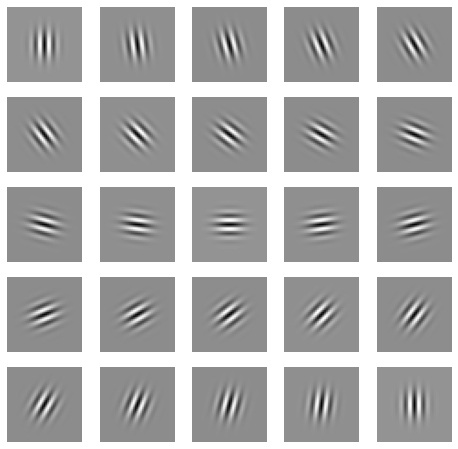

In [8]:
images = InsilicoStimuliSet().images(dict(set_hash='bbe7a4bb85011dba64d24d59ab20b77e'), canvas_size=[41, 41])

fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs = axs.flatten()

for ax, gabor in zip(axs, images):
    ax.imshow(gabor, cmap='gray')
    ax.axis('off')

## Optimisation Function

In [9]:
StimuliOptimizeMethod()

method_fn name of the set function,method_hash hash of the set config,method_config set configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the set


In [10]:
method_fn = 'insilico_stimuli.optimizers.bruteforce'
method_config = {
    'batch_size': 100
}

In [11]:
StimuliOptimizeMethod().add_method(method_fn=method_fn, method_config=method_config, comment='bf_batch_100')

In [12]:
StimuliOptimizeMethod()

method_fn name of the set function,method_hash hash of the set config,method_config set configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the set
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,=BLOB=,2020-12-09 19:46:29,bf_batch_100


## Optimised Stimuli Table
Stores and computes optimal stimuli for the provided set of stimuli.

In [13]:
@schema
class OptimisedStimuli(OptimisedStimuliTemplate, dj.Computed):
    """MEI table template.

    To create a functional "MEI" table, create a new class that inherits from this template and decorate it with your
    preferred Datajoint schema. Next assign your trained model (or trained ensemble model) and your selector table to
    the class variables called "trained_model_table" and "selector_table". By default, the created table will point to
    the "MEIMethod" table in the Datajoint schema called "nnfabrik.main". This behavior can be changed by overwriting
    the class attribute called "method_table".
    """

    trained_model_table = TrainedModel
    unit_table = Recording.Units

In [14]:
OptimisedStimuli()

method_fn name of the set function,method_hash hash of the set config,set_fn name of the set function,set_hash hash of the set config,model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,average_score average score depending on the used method function


In [15]:
OptimisedStimuli().Units()

method_fn name of the set function,method_hash hash of the set config,set_fn name of the set function,set_hash hash of the set config,model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,data_key,unit_id,unit_type,stimulus,score


Compute the optimal stimuli for each neuron for the given model

In [16]:
OptimisedStimuli().populate(dict(model_hash='f8bcd882c48a55dc6cd6d7afb656f1f9', seed='1000'))

In [17]:
OptimisedStimuli().Units()

method_fn name of the set function,method_hash hash of the set config,set_fn name of the set function,set_hash hash of the set config,model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,data_key,unit_id,unit_type,stimulus,score
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,1,1,=BLOB=,0.489093
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,2,1,=BLOB=,2.94203
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,3,1,=BLOB=,6.71341
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,4,1,=BLOB=,1.80807
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,5,1,=BLOB=,0.249504
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,6,1,=BLOB=,1.45608
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,7,1,=BLOB=,5.51326
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,8,1,=BLOB=,4.98934
insilico_stimuli.optimizers.bruteforce,531a53f0acae47bfa0c67acb2db6bd67,insilico_stimuli.stimuli.GaborSet,bbe7a4bb85011dba64d24d59ab20b77e,nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,3631807112901,9,1,=BLOB=,2.14852